In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from radio_lab_tools.spectrum import power_spectrum, compute_fft
from scipy.stats import norm

# My GitHub account and all related data can be found at https://github.com/arnaramirez/ASTRO-121/tree/main/Lab%201

## LAB 1 : Digital Sampling, Fourier Filtering, and Heterodyne Mixers in Radio Astronomy 

### 5. Digitally Sampling a Sine Wave

<h3 style="font-family: Arial; color: mediumblue;"> 5.3 Digital Sampling and the Nyquist Criterion </h3>

**Setup and Background:** We generated a 300 kHz sine wave with 2 mV peak-to-peak amplitude using the Keysight N9310A RF signal generator, verifying the signal on the RIGOL DS1052E oscilloscope and adjusting with 10 dB and 3 dB attenuators to remain below 3 mV. Data was collected with a Raspberry Pi and SDR in direct sampling mode at sampling rates of: $\upsilon_{s} = f_{s}$= 1.0, 1.25,  1.5, 2.0, 2.5, 3.0, and 3.2 MHz. The first 1.0 MHz dataset was discarded due to stale buffers, which contained residual values from previous captures. For each sampling rate, we collected a total of $N = 16,384$ samples plotted over a time window of approximately 100 µs, both with and without the FIR antialiasing filter enabled. This allows for the comparison of FIR filtering on waveform amplitude and aliasing behavior.  
  <br> 
  <br>

Given our input signal: $$ \upsilon_{0} = 300 \: \text{kHz} $$ <br>

and our sampling frequencies ($ \upsilon_{s} $) ranging from: 

$$\upsilon_{s} = 1.0 \: \text{to} \: 3.2 \: \text{MHz} $$ <br> 

The given Nyquist frequency is given by: $$ \upsilon_{\text{Nyq}} = \frac{\upsilon_{s}}{2} $$ <br>

where aliasing occurs when: $$ \upsilon_{0} \gt \frac{\upsilon_{s}}{2} $$ <br>
  <br>
  <br>

Because our selected input signal is $ \upsilon_{0} = 300 \: \text{kHz} $, all of our chosen sampling rates are above twice the signal frequency, remaining within the Nyquist zone.

To investigate aliasing, we asked: How does the FIR antialiasing filter supresss higher frequency components near the Nyquist frequency for a 300kHz signal?

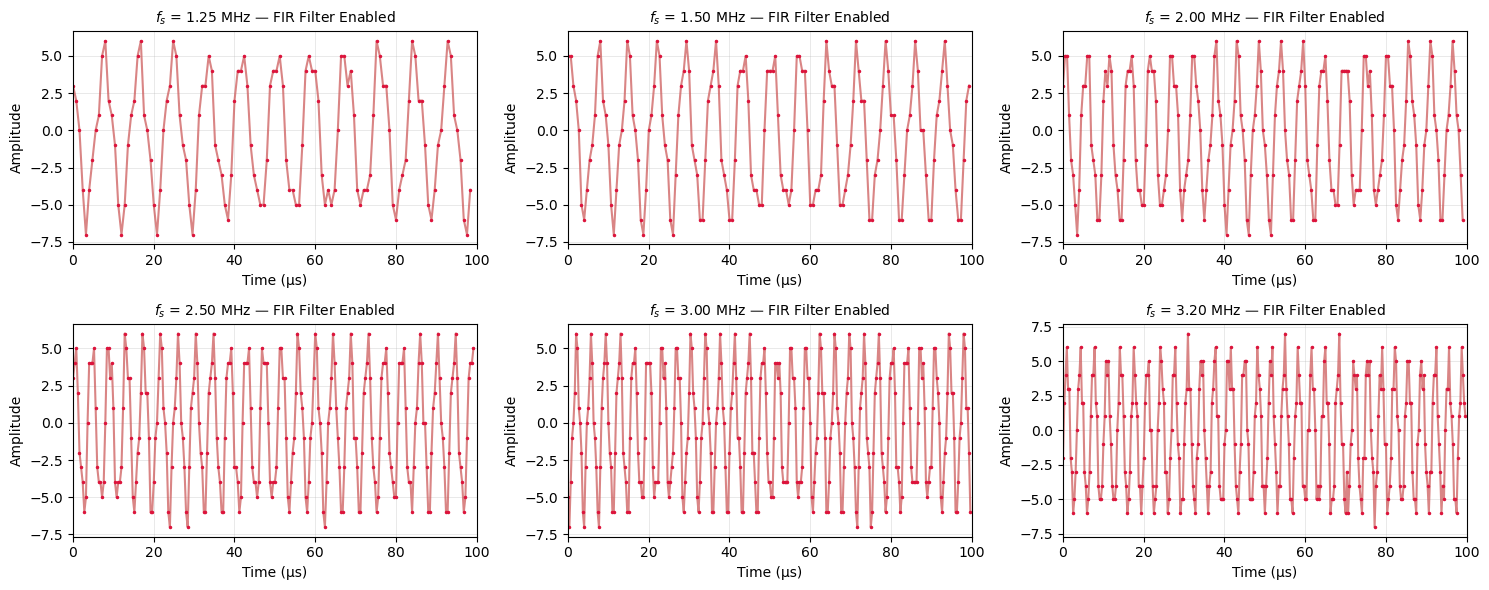

In [2]:
files = [
    "yFIRData1250000Hz.npz",
    "yFIRData1500000Hz.npz",
    "yFIRData2000000Hz.npz",
    "yFIRData2500000Hz.npz",
    "yFIRData3000000Hz.npz",
    "yFIRData3200000Hz.npz",
]

time_window_us = 100  # microseconds
nrows, ncols = 2, 3

plt.figure(figsize=(15, 6))

for i, fname in enumerate(files, start=1):
    data = np.load(fname)
    x = data["data"]
    fs = data["sample_rate"]    # where fs is equivalent to \upsilon_{s}

    nsamp = int(time_window_us * 1e-6 * fs)
    t_us = np.arange(nsamp) / fs * 1e6

    
    plt.subplot(nrows, ncols, i)
    plt.plot(t_us, x[:nsamp], color='indianred', alpha=0.75)
    plt.plot(t_us, x[:nsamp], 'o', markersize=1.5, color='crimson')

    plt.title(f"$f_s$ = {fs/1e6:.2f} MHz — FIR Filter Enabled", fontsize=10)
    plt.xlabel("Time (µs)")
    plt.ylabel("Amplitude")
    plt.xlim(0, time_window_us)
    plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.4)

plt.tight_layout()
plt.show()

These plots demonstrate the 300 kHz sinusoid signal sampled over time at multiple rates with the FIR anti-aliasing filer **enabled**. The observed amplitude remains roughly constant (~ 5) at lower sampling rates (1.25 - 3.0 MHz) and increases at the highest rate (3.2 MHz). This demonstrates that the FIR filter suppresses higher frequency components near the Nyquist frequency, preventing aliasing and preserving the sampled signal.

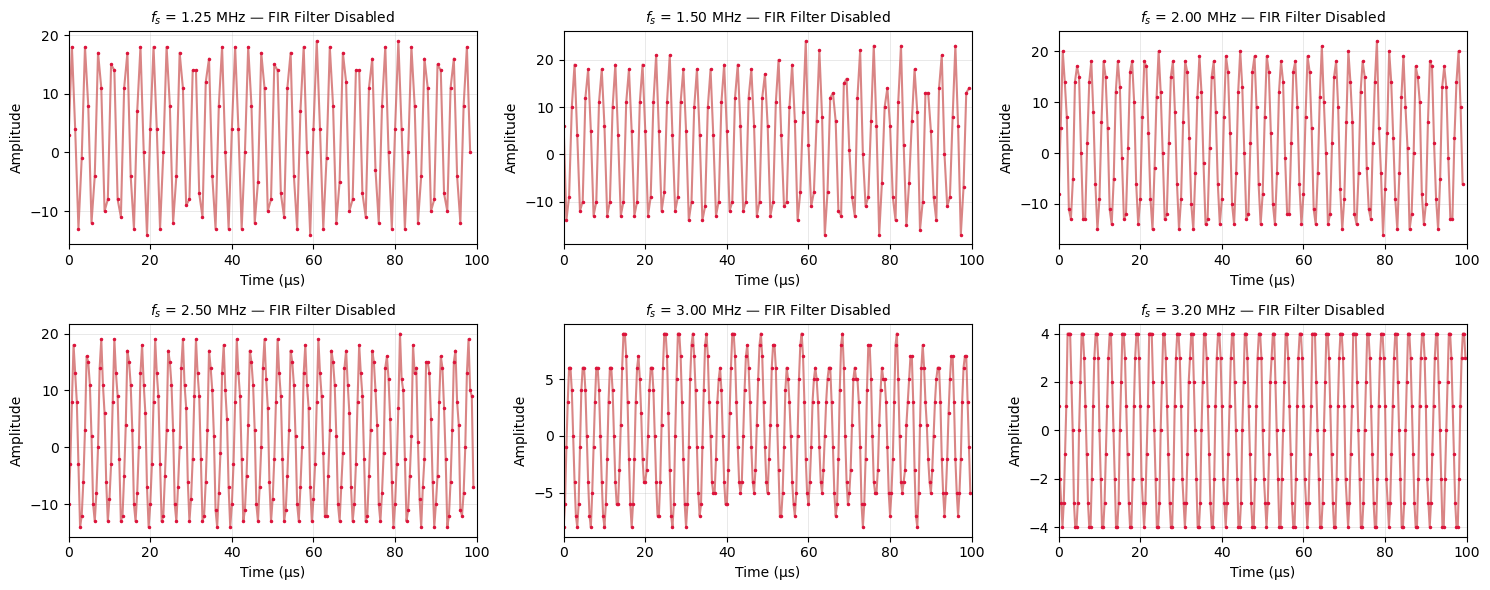

In [3]:
files = [
    "nFIRData1250000Hz.npz",
    "nFIRData1500000Hz.npz",
    "nFIRData2000000Hz.npz",
    "nFIRData2500000Hz.npz",
    "nFIRData3000000Hz.npz",
    "nFIRData3200000Hz.npz",
]

time_window_us = 100  # microseconds
nrows, ncols = 2, 3

plt.figure(figsize=(15, 6))

for i, fname in enumerate(files, start=1):
    data = np.load(fname)
    x = data["data"]
    fs = data["sample_rate"]    # where fs is equivalent to \upsilon_{s}

    nsamp = int(time_window_us * 1e-6 * fs)
    t_us = np.arange(nsamp) / fs * 1e6

    
    plt.subplot(nrows, ncols, i)
    plt.plot(t_us, x[:nsamp], color='indianred', alpha=0.75)
    plt.plot(t_us, x[:nsamp], 'o', markersize=1.5, color='crimson')

    plt.title(f"$f_s$ = {fs/1e6:.2f} MHz — FIR Filter Disabled", fontsize=10)
    plt.xlabel("Time (µs)")
    plt.ylabel("Amplitude")
    plt.xlim(0, time_window_us)
    plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.4)

plt.tight_layout()
plt.show()

These plots demonstrate the 300 kHz sinusoid signal sampled over time at multiple rates with the FIR anti-aliasing filter **disabled**. The observed amplitude starts high (~17- 20) at low sampling rates (1.25 - 2.50 MHz) and decreases dramatically at the highest two rates (3.0, 3.2 MHz). This is due to folding of higher Nyquist zones into the baseband. This illustrates the importance of anti-aliasing filters in the prevention of distorted sampled waveforms that misrepresent the true signal amplitude.

In [23]:
files_fir_enabled = [
    "yFIRData1250000Hz.npz",
    "yFIRData1500000Hz.npz",
    "yFIRData2000000Hz.npz",
    "yFIRData2500000Hz.npz",
    "yFIRData3000000Hz.npz",
    "yFIRData3200000Hz.npz",
]

files_fir_disabled = [
    "nFIRData1250000Hz.npz",
    "nFIRData1500000Hz.npz",
    "nFIRData2000000Hz.npz",
    "nFIRData2500000Hz.npz",
    "nFIRData3000000Hz.npz",
    "nFIRData3200000Hz.npz",
]


sampling_rates = [1.25e6, 1.5e6, 2.0e6, 2.5e6, 3.0e6, 3.2e6]

print(f"{'Fs (MHz)':>10} | {'Max Amp FIR':>12} | {'Max Amp No FIR':>14} | {'Drop (%)':>10}")
print("-"*55)

for fs, f_fir, f_no in zip(sampling_rates, files_fir_enabled, files_fir_disabled):
    data_fir = np.load(f_fir)["data"]
    data_no = np.load(f_no)["data"]

    max_fir = np.max(np.abs(data_fir))
    max_no = np.max(np.abs(data_no))

    drop_pct = (max_fir - max_no) / max_fir * 100

    print(f"{fs/1e6:10.2f} | {max_fir:12.4f} | {max_no:14.4f} | {drop_pct:10.2f}")

  Fs (MHz) |  Max Amp FIR | Max Amp No FIR |   Drop (%)
-------------------------------------------------------
      1.25 |       7.0000 |        19.0000 |    -171.43
      1.50 |       7.0000 |        24.0000 |    -242.86
      2.00 |       7.0000 |        23.0000 |    -228.57
      2.50 |       7.0000 |        24.0000 |    -242.86
      3.00 |       7.0000 |         9.0000 |     -28.57
      3.20 |       7.0000 |         5.0000 |      28.57


**Conclusion:** These results demonstrate the necessity of anti-aliasing filters in practical SDR sampling. With the FIR filter enabled, the amplitude fluctuations are much smaller than without the filter, indicating that the anti-aliasing filter effectively reduces contributions from higher Nyquist zones.

To answer our original question:  



The signal amplitude without the FIR filter decreases significantly as the sampling rate approaches the Nyquist limit (approaching at 3.0–3.2 MHz). With the FIR filter enabled, the amplitude remains more stable across all sampling rates, demonstrating that high frequency components near the Nyquist frequency are effectively suppressed. Comparing the plots also shows that the filter reduces distortions, preventing aliasing and preserving the original signal waveform. Quantitatively, the maximum baseband amplitude with the FIR filter remains steady at $X\approx 7$  whereas without the FIR filter amplitudes range from $X=19 $ to $5$.

<h3 style="font-family: Arial; color: mediumblue;"> 5.4 Voltage Spectra and Power Spectra </h3>

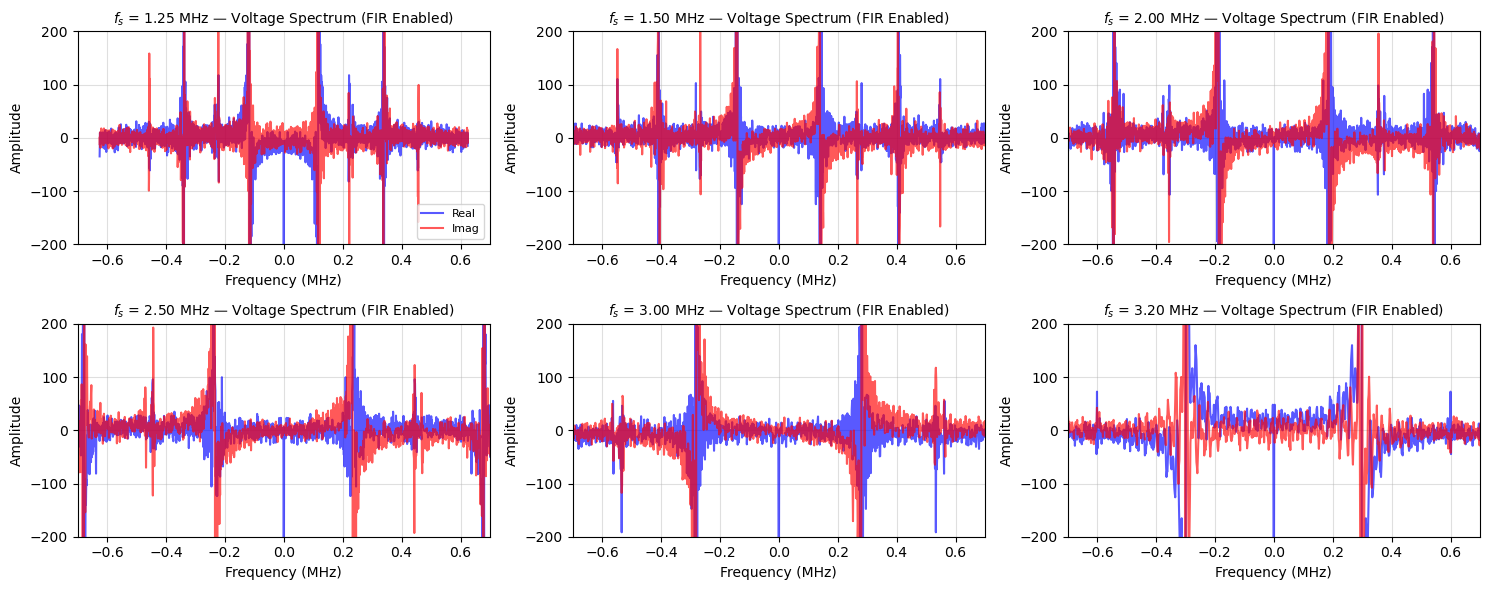

In [4]:
# Plotting the real and imaginary voltage spectrum for 6 sample rates
files = [
    "yFIRData1250000Hz.npz",
    "yFIRData1500000Hz.npz",
    "yFIRData2000000Hz.npz",
    "yFIRData2500000Hz.npz",
    "yFIRData3000000Hz.npz",
    "yFIRData3200000Hz.npz",
]

plt.figure(figsize=(15, 6))

for i, fname in enumerate(files, start=1):
    data = np.load(fname)
    x = data["data"]
    fs = data["sample_rate"]
    N = len(x)

    spec = np.fft.fft(x)
    freqs = np.fft.fftfreq(N, d=1/fs)

    spec = np.fft.fftshift(spec)
    freqs = np.fft.fftshift(freqs)

    plt.subplot(2, 3, i)
    plt.plot(freqs / 1e6, spec.real,
             color="blue", linestyle="-", alpha=0.65, label="Real")
    plt.plot(freqs / 1e6, spec.imag,
             color="red", linestyle="-", alpha=0.65, label="Imag")

    plt.title(f"$f_s$ = {fs/1e6:.2f} MHz — Voltage Spectrum (FIR Enabled)", fontsize=10)
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Amplitude")
    plt.ylim(-200, 200)
    plt.xlim(-0.7, 0.7)
    plt.grid(True, linestyle="-", alpha=0.4)

    if i == 1:
        plt.legend(fontsize=8, loc= 'lower right')

plt.tight_layout()
plt.show()

This figure demonstrates the voltage spectra $\tilde{E}(\upsilon)$ of a 300 kHz sinusoidal signal sampled at 6 different sampling rates with the FIR anti-aliasing filter enabled. The voltage spectrum retains both amplitude and phase information, represented by real and imaginary components, which exhibit even and odd symmetry about the zero frequency, respectively. Because the voltage signal we measured is real, its Fourier transform exhibits conjugate symmetry  (with the real part even and the imaginary part odd in frequency). The voltage spectrum retains the phase information to reconstruct the signal, while the power spectrum eliminats phase information and retains only the energy distribution across frequencies.

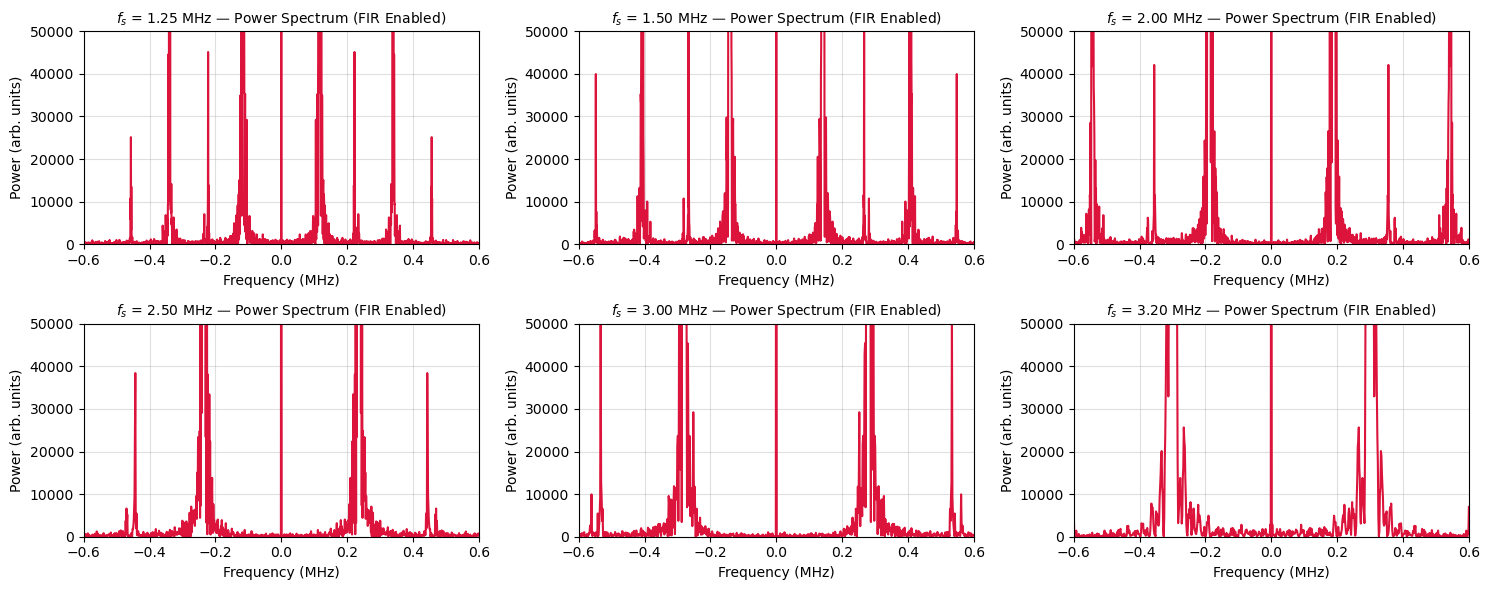

In [5]:
# Plotting the power spectrum for 6 sample rates
files = [
    "yFIRData1250000Hz.npz",
    "yFIRData1500000Hz.npz",
    "yFIRData2000000Hz.npz",
    "yFIRData2500000Hz.npz",
    "yFIRData3000000Hz.npz",
    "yFIRData3200000Hz.npz",
]

plt.figure(figsize=(15, 6))

for i, fname in enumerate(files, start=1):
    data = np.load(fname)
    x = data["data"]
    fs = data["sample_rate"]
    N = len(x)

    spec = np.fft.fft(x)
    freqs = np.fft.fftfreq(N, d=1/fs)

    power = np.abs(spec)**2

    power = np.fft.fftshift(power)
    freqs = np.fft.fftshift(freqs)

    plt.subplot(2, 3, i)
    plt.plot(freqs / 1e6, power, color="crimson")

    plt.title(f"$f_s$ = {fs/1e6:.2f} MHz — Power Spectrum (FIR Enabled)", fontsize=10)
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Power (arb. units)")
    plt.ylim(0,5e4)
    plt.xlim(-0.6, 0.6)
    plt.grid(True, linestyle="-", alpha=0.4)

plt.tight_layout()
plt.show()

This figure shows the power spectra $P_{\upsilon}$ corresponding to the same six sampling rates, computed from the magnitude squared of the voltage spectrum ($P_{\upsilon}= \tilde{E}(\upsilon)\cdot\tilde{E^*}(\upsilon)$). The power spectrum quantifies how signal energy is distributed across frequency and is nonnegative. Strong peaks at $\pm 300$ kHz ($= \pm 0.3$ MHz) indicate the dominant frequency content of the input signal, while suppression near the Nyquist frequency reflects the effect of FIR anti-aliasing filtering. Power spectra are preferred when summarizing frequency content and/or total signal power.

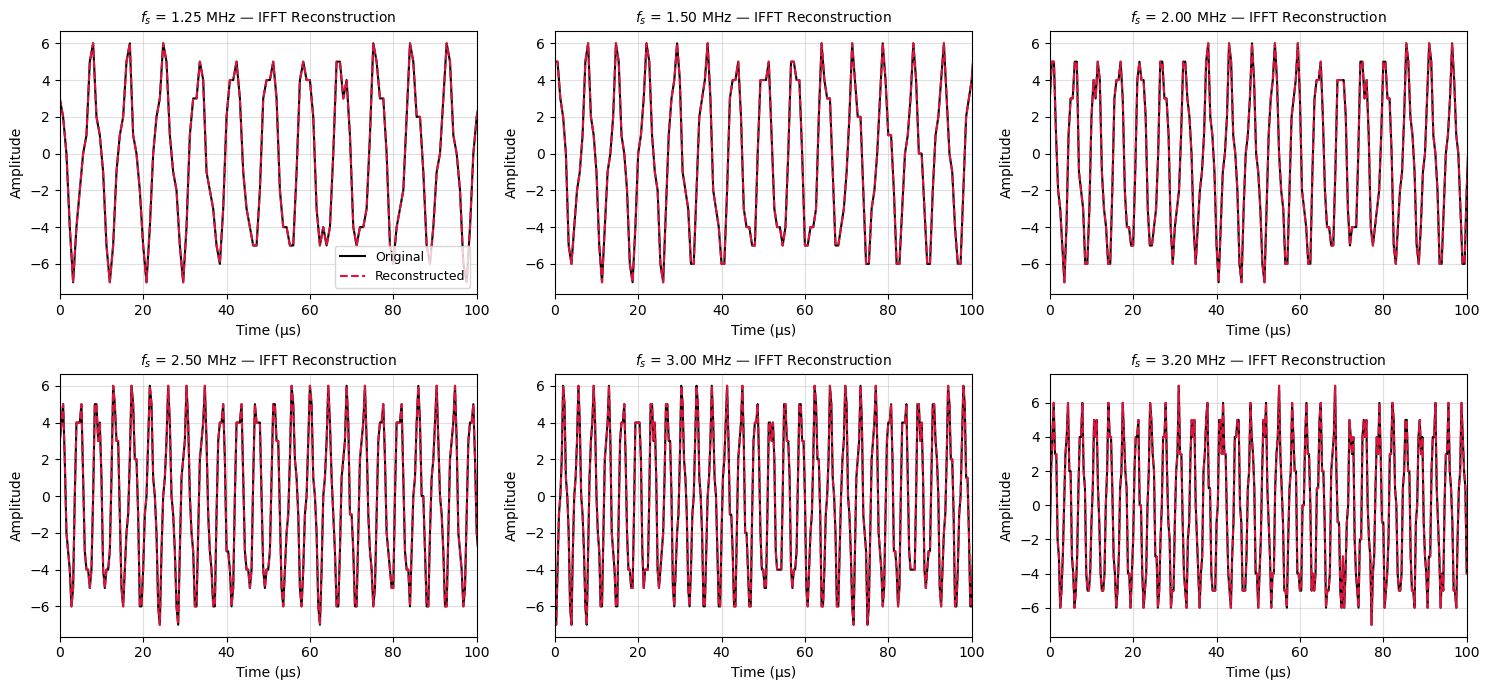

In [6]:
files = [
    "yFIRData1250000Hz.npz",
    "yFIRData1500000Hz.npz",
    "yFIRData2000000Hz.npz",
    "yFIRData2500000Hz.npz",
    "yFIRData3000000Hz.npz",
    "yFIRData3200000Hz.npz",
]

plt.figure(figsize=(15, 7))

for i, fname in enumerate(files, start=1):
    data = np.load(fname)
    x = data["data"]
    fs = data["sample_rate"]
    N = len(x)

    spec = np.fft.fft(x)
    x_reconstructed = np.fft.ifft(spec)

    t_us = np.arange(N) / fs * 1e6

    
    plt.subplot(2, 3, i)
    plt.plot(t_us, x, alpha=1,
            color="black", label="Original")
    plt.plot(t_us, x_reconstructed.real,
             linestyle="--", color="crimson", alpha=1, label="Reconstructed")

    plt.title(f"$f_s$ = {fs/1e6:.2f} MHz — IFFT Reconstruction", fontsize=10)
    plt.xlabel("Time (µs)")
    plt.ylabel("Amplitude")
    plt.xlim(0,100)
    plt.grid(True, linestyle="-", alpha=0.4)

    if i == 1:
        plt.legend(fontsize=9, loc= 'lower right')

plt.tight_layout()
plt.show()

This figure plots the original time domain voltage signal to the signal reconstructed using the inverse Fourier transform for each sampling rate. The reconstructed wave closely overlaps the original signal, showing that the Fourier transform preserves all information required to recover the original time series. This demonstrates that when sampling conditions satisfy the Nyquist criterion, the voltage spectrum retains necessary information to reconstruct the signal.

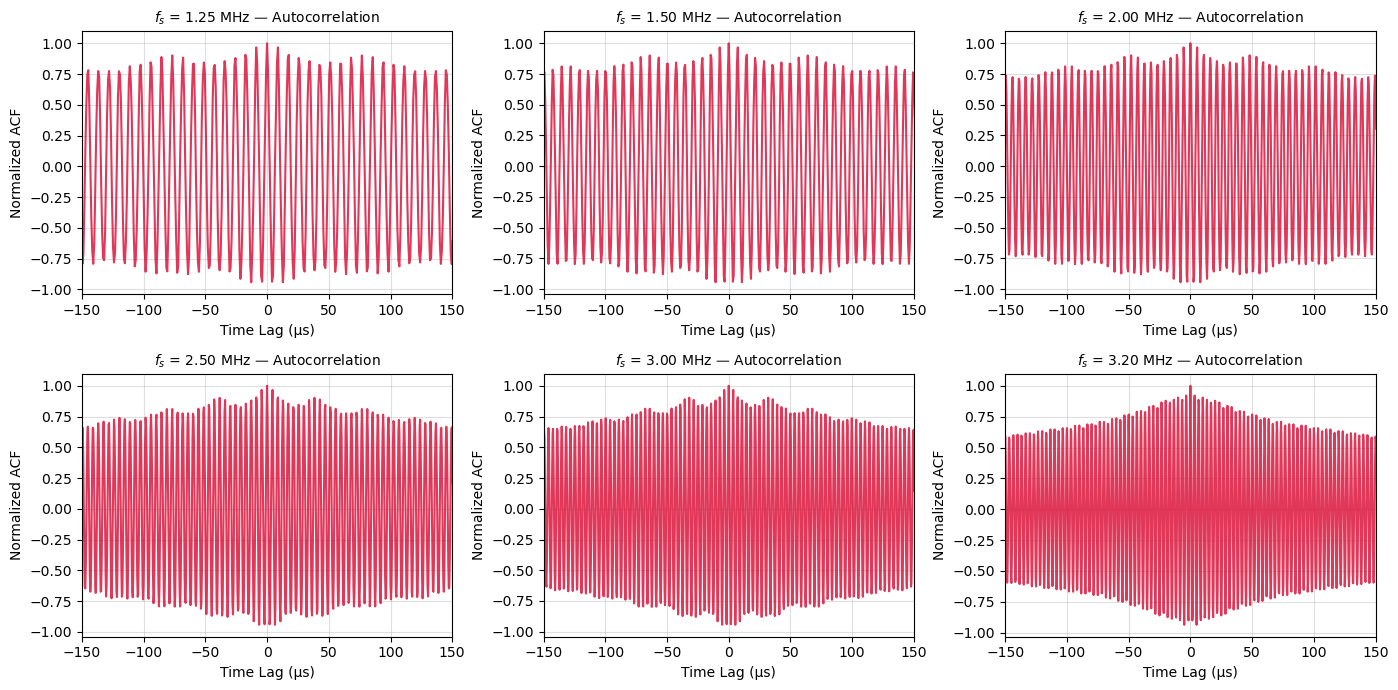

In [7]:
files = [
    "yFIRData1250000Hz.npz",
    "yFIRData1500000Hz.npz",
    "yFIRData2000000Hz.npz",
    "yFIRData2500000Hz.npz",
    "yFIRData3000000Hz.npz",
    "yFIRData3200000Hz.npz",
]

plt.figure(figsize=(14, 7))

for i, fname in enumerate(files, start=1):
    data = np.load(fname)
    x = data["data"]
    fs = data["sample_rate"]
    N = len(x)

    x = x - np.mean(x)

    acf = np.correlate(x, x, mode="full")
    acf = acf / np.max(acf)

    lags = np.arange(-N + 1, N) / fs * 1e6

    plt.subplot(2, 3, i)
    plt.plot(lags, acf, color="crimson", alpha=0.85)

    plt.title(f"$f_s$ = {fs/1e6:.2f} MHz — Autocorrelation", fontsize=10)
    plt.xlabel("Time Lag (µs)")
    plt.ylabel("Normalized ACF")
    plt.xlim(-150, 150)
    plt.grid(True, linestyle="-", alpha=0.4)

plt.tight_layout()
plt.show()

This figure shows the autocorrelation functions computed directly from the voltage time series for a 300 kHz sinusoidal input at 6 sampling rates. The oscillatory nature of the plotted signal reflects the periodic nature of the 300 kHz sinusoidal input, where the peak at zero lag corresponds to maximum similarity when the signal is aligned with itselfwith, and peaks separated by the signal period. The decrease in autocorrelation amplitude at large time lags happens due to finite data length, since fewer overlapping samples contribute to the correlation as the lag increases, producing a "taper".

**Conclusion**: We utilized voltage spectra to preserve both amplitude and phase information, while examining the real and imaginary components, conjugate symmetry, and reconstruction of a signal. The appearance of conjugate symmetry and paired positive and negative frequencies reflects the real valued nature of the signal, with real and imaginary components encoding cosine and sine phase contributions, respectively: 
<bv>   
<bv>  
$$ \tilde{E}(\upsilon) = A(\upsilon)cos(\omega(\upsilon))+iA(\upsilon)sin(\omega(\upsilon))$$   
This representation leads to conjugate symmetry in the frequency domain, with paired positive and negative frequencies that carry identical amplitude information but opposite phase, such that a negative frequency corresponds to the same oscillation as a positive frequency. The autocorrelation function displays oscillatory behavior at the signal frequency of 300 kHz with a decreasing amplitude at larger time lags, due to finite data length reducing the number of overlapping samples contributing to the correlation

<h3 style="font-family: Arial; color: mediumblue;"> 5.5 Leakage Power </h3>

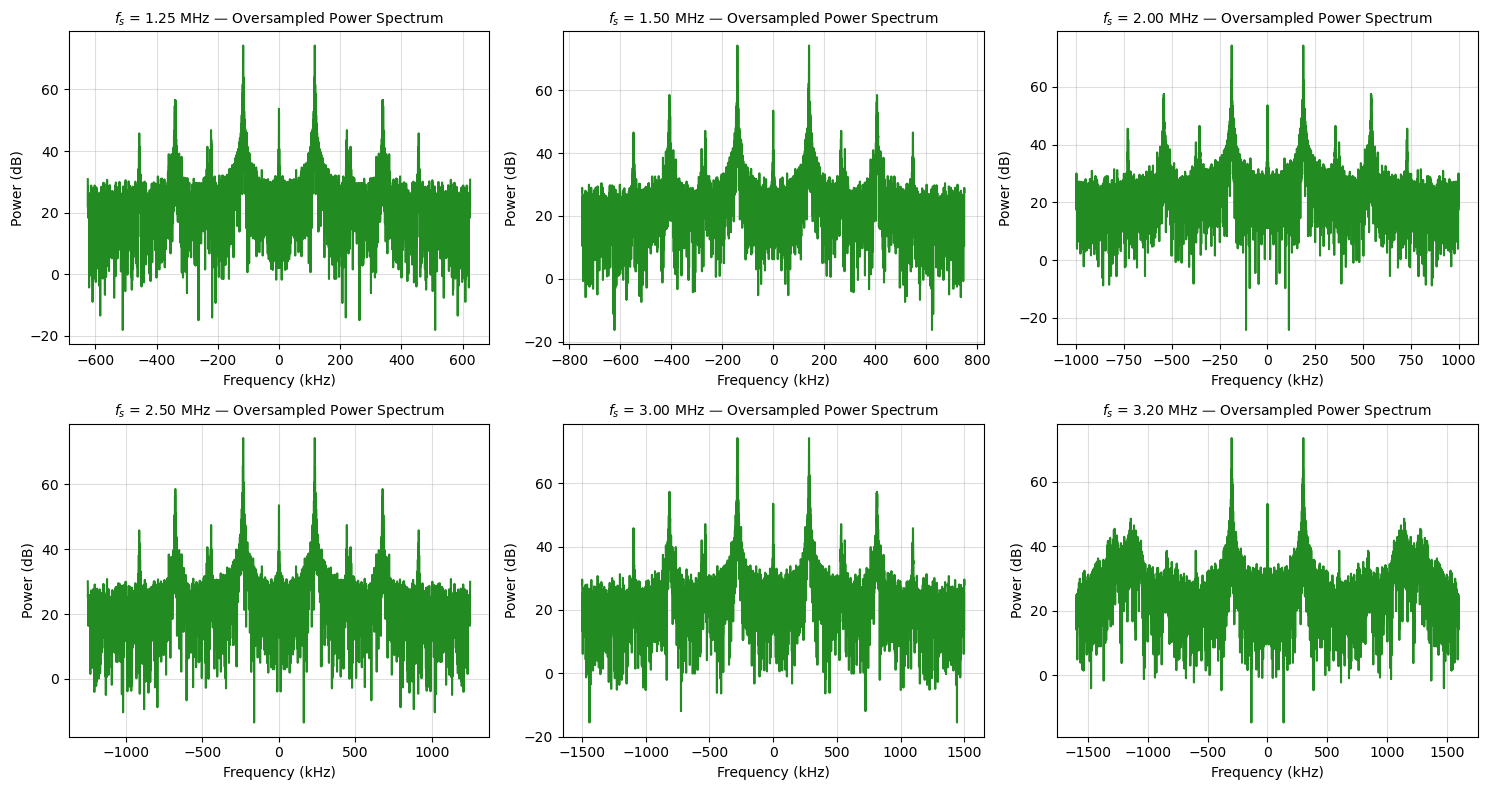

In [8]:
#not completed using ugradio.dft
files = [
    "yFIRData1250000Hz.npz",
    "yFIRData1500000Hz.npz",
    "yFIRData2000000Hz.npz",
    "yFIRData2500000Hz.npz",
    "yFIRData3000000Hz.npz",
    "yFIRData3200000Hz.npz",
]

pad_factor = 10 

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for ax, fname in zip(axes, files):

    data = np.load(fname)
    x = data["data"]
    fs = data["sample_rate"]
    N = len(x)

    Npad = pad_factor * N
    
    spec = np.fft.fft(x, n=Npad)
    freqs = np.fft.fftfreq(Npad, d=1/fs)
    
    spec = np.fft.fftshift(spec)
    freqs = np.fft.fftshift(freqs)
    
    # computing the power spectrum in dB
    power_db = 10 * np.log10(np.abs(spec)**2)
    
    ax.plot(freqs/1e3, power_db, color='forestgreen')
    ax.set_title(f"$f_s$ = {fs/1e6:.2f} MHz — Oversampled Power Spectrum", fontsize=10)
    ax.set_xlabel("Frequency (kHz)")
    ax.set_ylabel("Power (dB)")
    ax.grid(alpha=0.4)

plt.tight_layout()
plt.show()

These plots display the oversampled power spectra of the 300 kHz sine wave with the FIR filter enabled at six different sampling rates. The main peak does not appear at 300 kHz in these plots because of aliasing, where the signal has folded onto the first Nyquist zone. Smaller bumps around the peak show spectral leakage, which happens because the signal is only sampled for a finite amount of time. Mathematically, this can be explained using the Convolution Theorem, which states that multiplying a signal by a time window spreads its power into nearby frequencies. 

<h3 style="font-family: Arial; color: mediumblue;"> 5.6 Frequency Resolution </h3>

**Setup:** We generated two sinusoidal signals at 300 kHz and 300.5 kHz using two RF signal generators combined with a power splitter. Both signals were set to 2.0 mV peak-to-peak amplitude. The signals were sampled using an SDR in direct mode at several sampling rates (1.0, 2.0, 2.5, 3.0, and 3.2 MHz), and for each sampling rate we varied the number of samples N = 2048, 4096, 8192, and 16384 to explore how the frequency resolution of the Fourier Transform depends on the length of the sampled data. I will be focusing on N = 2048 and 16384 to demonstrate two extremes of the number of samples.

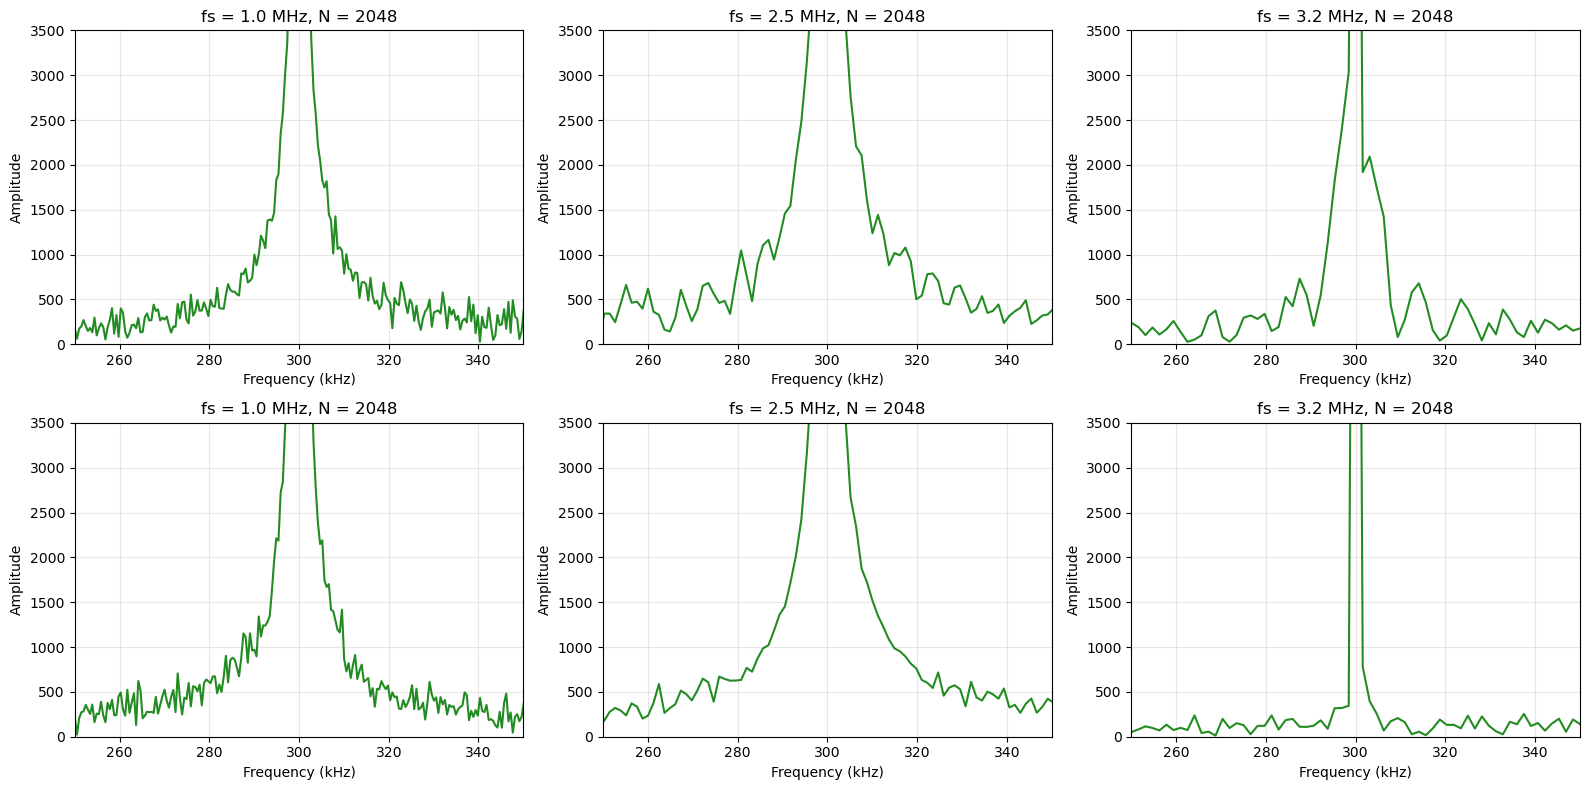

In [9]:
files = [
    "FreqRes1000000.0Hz2048.npz",
    "FreqRes2500000.0Hz2048.npz",
    "FreqRes3200000.0Hz2048.npz",
    "FreqRes1000000.0Hz16384.npz",
    "FreqRes2500000.0Hz16384.npz",
    "FreqRes3200000.0Hz16384.npz",
]

plt.figure(figsize=(16,8))

for i, fname in enumerate(files, 1):
    data = np.load(fname)
    x = data["data"]
    fs = data["sample_rate"]
    N = len(x)
    
    spec = np.fft.fftshift(np.fft.fft(x))
    freqs = np.fft.fftshift(np.fft.fftfreq(N, 1/fs))
    
    plt.subplot(2, 3, i)
    plt.plot(freqs/1e3, np.abs(spec), color='forestgreen')
    plt.xlabel("Frequency (kHz)")
    plt.ylabel("Amplitude")
    plt.ylim(0, 3500)
    plt.xlim(250, 350)
    plt.title(f"fs = {fs/1e6:.1f} MHz, N = {N}")
    plt.grid(True, linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

These plots show the power spectra of two closely spaced sine waves at 300 kHz and 300.5 kHz for three sampling rates (1.0, 2.5, 3.2 MHz) with two different numbers of samples: N = 2048 (top row) and N = 16384 (bottom row). Increasing N significantly sharpens the spectral peaks, improving the frequency resolution and allowing the two signals to be resolved more clearly. The spacing between adjacent frequency bins is given by $ \Delta \nu = \frac{\nu_s}{N} $, which explains why larger N reduces the width of each bin and separates closely spaced lines. This demonstrates that the number of samples directly controls the minimum distinguishable spectral separation in a Fourier Transform.

In [10]:
sampling_freqs = [1.0e6, 2.5e6, 3.2e6]  # [Hz]
N_values = [2048, 16384] 
signal_sep = 500  # 300.5 kHz - 300 kHz = 

for fs in sampling_freqs:
    print(f"\nSampling frequency: {fs/1e6:.2f} MHz")
    for N in N_values:
        delta_nu = fs / N
        can_resolve = delta_nu <= signal_sep
        print(f"  N = {N}: Δν = {delta_nu:.1f} Hz", end="")
        if can_resolve:
            print(" → Can resolve 0.5 kHz separation")
        else:
            print(" → Cannot fully resolve 0.5 kHz separation")


Sampling frequency: 1.00 MHz
  N = 2048: Δν = 488.3 Hz → Can resolve 0.5 kHz separation
  N = 16384: Δν = 61.0 Hz → Can resolve 0.5 kHz separation

Sampling frequency: 2.50 MHz
  N = 2048: Δν = 1220.7 Hz → Cannot fully resolve 0.5 kHz separation
  N = 16384: Δν = 152.6 Hz → Can resolve 0.5 kHz separation

Sampling frequency: 3.20 MHz
  N = 2048: Δν = 1562.5 Hz → Cannot fully resolve 0.5 kHz separation
  N = 16384: Δν = 195.3 Hz → Can resolve 0.5 kHz separation


The minimum distinguishable spacing between two spectral lines is determined by the frequency resolution of the Fourier Transform, given by $ \Delta \nu = \frac{\nu_s}{N} $, where $\nu_{s}$ is the sampling frequency and N is the number of samples. By combining two sine waves at 300~kHz and 300.5 kHz using a power splitter, we observed that smaller N values produce broad spectral peaks that merge, whereas larger N values produce narrower peaks that clearly resolve the two frequencies. This happens because multiplying a finite-length signal by a rectangular window is equivalent, via the Convolution Theorem, to convolving the signal’s ideal spectrum with a sinc function in the frequency domain, which spreads the spectral energy and reduces resolution. In other words, increasing N narrows this convolution and improves the ability to distinguish more closely spaced lines.

<h3 style="font-family: Arial; color: mediumblue;"> 5.7 Power Spectra in Other Nyquist Windows </h3>

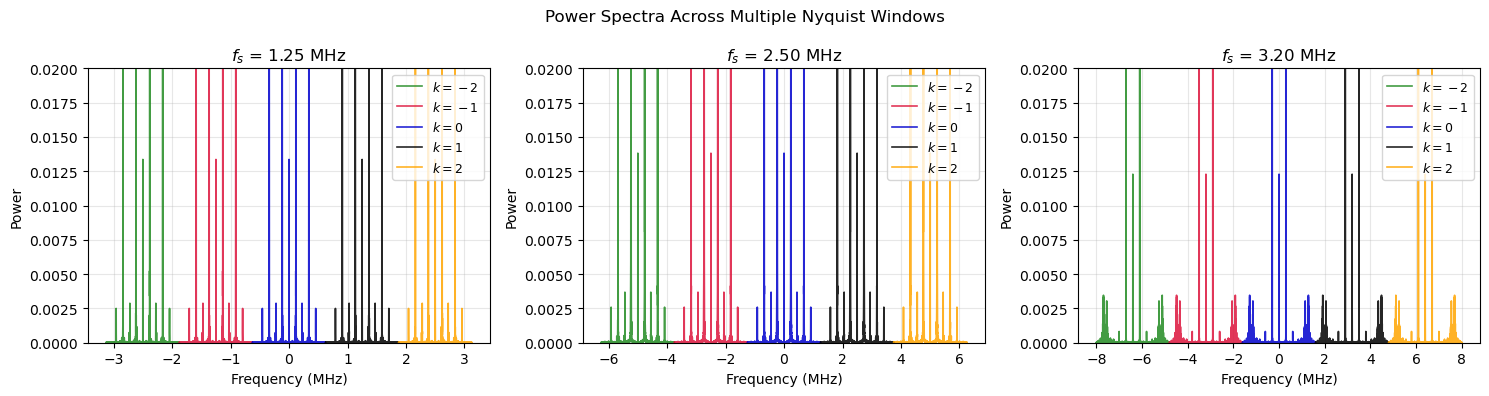

In [11]:
files = {
    1.25e6: "yFIRData1250000Hz.npz",
    2.5e6: "yFIRData2500000Hz.npz",
    3.2e6: "yFIRData3200000Hz.npz",
}

W = 4

window_colors = {
    -2: "forestgreen",
    -1: "crimson",
     0: "mediumblue",
     1: "black",
     2: "orange",
}

plt.figure(figsize=(15, 4))

for i, (fs, fname) in enumerate(files.items(), 1):
    data = np.load(fname)
    x = data["data"]

    f, P = power_spectrum(x, fs)

    plt.subplot(1, 3, i)

    for k in window_colors:
        plt.plot(
            (f + k*fs)/1e6,
            P,
            color=window_colors[k],
            label=f"$k = {k}$",
            linewidth=1.2,
            alpha=0.85
        )

    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Power")
    plt.ylim(0,0.02)
    plt.title(f"$f_s$ = {fs/1e6:.2f} MHz")
    plt.grid(True, linestyle='-', alpha=0.3)
    plt.legend(fontsize=9)

plt.suptitle("Power Spectra Across Multiple Nyquist Windows", fontsize=12)
plt.tight_layout()
plt.show()

These plots show the power spectra of a 300 kHz sinusoidal input sampled at 1.25, 2.5, and 3.2 MHz, extended across five different Nyquist windows ($k = -2$ to $2$). Each colored window shows the frequency range ±$f_s/2$ corresponding to that Nyquist zone, with widths scaling according to the sampling rate (higher sampling rate resulting in a wider frequency band). The original signal fits within the first Nyquist zone, so even when we look at higher Nyquist windows, the repeated spectra just appear at shifted frequencies. This shows that the signal can be “copied” into these other windows without causing distortion, because its bandwidth is smaller than the sampling frequency.

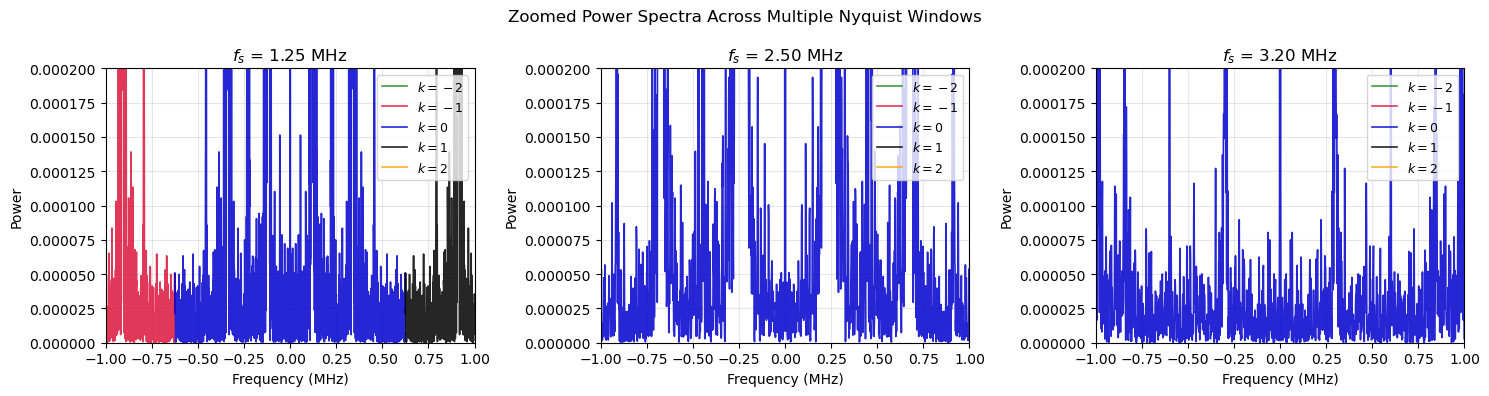

In [12]:
files = {
    1.25e6: "yFIRData1250000Hz.npz",
    2.5e6: "yFIRData2500000Hz.npz",
    3.2e6: "yFIRData3200000Hz.npz",
}

W = 4

window_colors = {
    -2: "forestgreen",
    -1: "crimson",
     0: "mediumblue",
     1: "black",
     2: "orange",
}

plt.figure(figsize=(15, 4))

for i, (fs, fname) in enumerate(files.items(), 1):
    data = np.load(fname)
    x = data["data"]

    f, P = power_spectrum(x, fs)

    plt.subplot(1, 3, i)

    for k in window_colors:
        plt.plot(
            (f + k*fs)/1e6,
            P,
            color=window_colors[k],
            label=f"$k = {k}$",
            linewidth=1.2,
            alpha=0.85
        )

    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Power")
    plt.ylim(0,0.0002)
    plt.xlim(-1,1)
    plt.title(f"$f_s$ = {fs/1e6:.2f} MHz")
    plt.grid(True, linestyle='-', alpha=0.3)
    plt.legend(fontsize=9, loc='upper right')

plt.suptitle("Zoomed Power Spectra Across Multiple Nyquist Windows", fontsize=12)
plt.tight_layout()
plt.show()

This plot zooms in on the same spectra as the figure above to show the baseband region in further detail.

<h3 style="font-family: Arial; color: mediumblue;"> 5.8.1 Laboratory Noise Generator </h3>

**Setup**: For this portion of the lab, we sampled broadband noise from the Laboratory Noise Generator (NOD5250) with the attenuator set to 5. Unlike we were instructed to, we did not use a bandpass filter, so the full noise spectrum was captured directly. Data were collected at a sampling rate of 1.0 MHz in multiple blocks, with block sizes of 16,384 and 65,536 samples, and varying numbers of blocks (N = 2, 4, 8, 16).

16384 samples/block, N=2 blocks: mean=-7.9509, variance=325.6474
16384 samples/block, N=4 blocks: mean=-7.9931, variance=327.5630
16384 samples/block, N=16 blocks: mean=-7.9875, variance=329.6145
65536 samples/block, N=2 blocks: mean=-7.9541, variance=330.5610
65536 samples/block, N=4 blocks: mean=-7.9310, variance=330.8094
65536 samples/block, N=16 blocks: mean=-7.9191, variance=330.8449


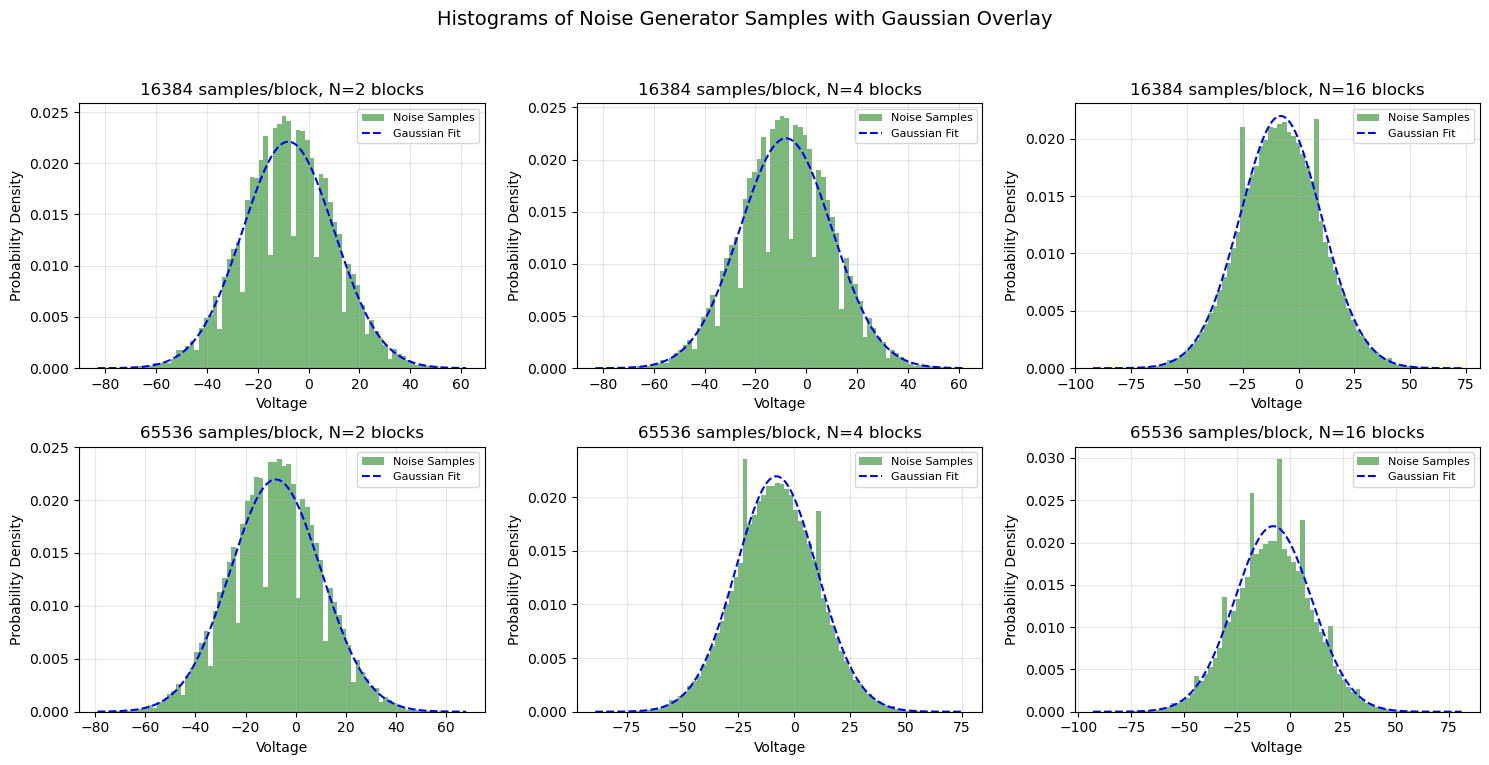

In [13]:
files = {
    16384: "noise_1000000Hz_16blocks_16384samples.npz",
    65536: "noise_1000000Hz_16blocks_65536samples.npz"
}


blocks_to_analyze = [2, 4, 16] 

plt.figure(figsize=(15, 8))

for row_idx, (nsamples, fname) in enumerate(files.items()):
    data = np.load(fname)['data']
    
    for col_idx, n_blocks in enumerate(blocks_to_analyze):
        combined_samples = data[:n_blocks].flatten() 
        mu = np.mean(combined_samples)
        sigma = np.std(combined_samples)
        
        print(f"{nsamples} samples/block, N={n_blocks} blocks: mean={mu:.4f}, variance={sigma**2:.4f}")
        
        plt.subplot(2, 3, row_idx*3 + col_idx + 1)
        plt.hist(combined_samples, bins=80, density=True, alpha=0.6, color='forestgreen', label='Noise Samples')
        
        xvals = np.linspace(np.min(combined_samples), np.max(combined_samples), 1000)
        plt.plot(xvals, norm.pdf(xvals, mu, sigma), color='blue',  linestyle='--', label='Gaussian Fit')
        
        plt.xlabel("Voltage")
        plt.ylabel("Probability Density")
        plt.title(f"{nsamples} samples/block, N={n_blocks} blocks")
        plt.legend(fontsize=8)
        plt.grid(True, alpha=0.3)

plt.suptitle("Histograms of Noise Generator Samples with Gaussian Overlay", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

These histograms show the voltage distributions of a noise generator sampled at 1.0 MHz for two different block sizes: 16,384 samples per block (top row) and 65,536 samples per block (bottom row). Each subplot contains multiple blocks (N = 2, 4, 16) to illustrate the effect of time averaging on the distribution. The blue dashed curves show Gaussian fits using the measured mean and standard deviation, demonstrating that the noise closely follows a normal distribution. There are some gaps in the data, which may have been due to the missing bandpass filter, but still follows a gaussian shape. As more blocks are averaged, the distribution narrows, reflecting the expected decrease in variance as expected from the Central Limit Theorem.

File noise_1000000Hz_2blocks_16384samples.npz only has 1 blocks, adjusting Nblocks.
File noise_1000000Hz_4blocks_16384samples.npz only has 3 blocks, adjusting Nblocks.
File noise_1000000Hz_16blocks_16384samples.npz only has 15 blocks, adjusting Nblocks.
File noise_1000000Hz_2blocks_65536samples.npz only has 1 blocks, adjusting Nblocks.
File noise_1000000Hz_4blocks_65536samples.npz only has 3 blocks, adjusting Nblocks.
File noise_1000000Hz_16blocks_65536samples.npz only has 15 blocks, adjusting Nblocks.


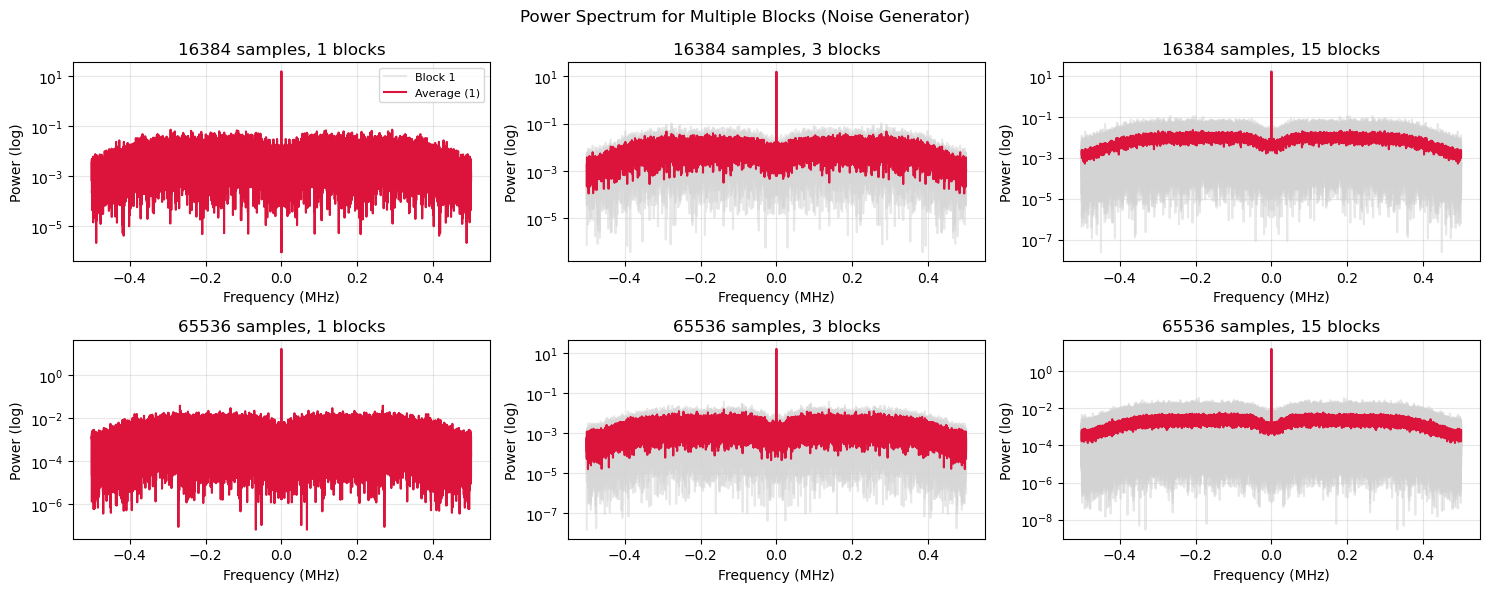

In [14]:
sample_sizes = [16384, 65536]   
Ns = [2, 4, 16]   
fs = 1.0e6

plt.figure(figsize=(15, 6))

for row_idx, Nsamples in enumerate(sample_sizes):
    for col_idx, Nblocks in enumerate(Ns):
        fname = f"noise_1000000Hz_{Nblocks}blocks_{Nsamples}samples.npz"
        data = np.load(fname)["data"]  # shape might be (actual_blocks, Nsamples)
        actual_blocks = data.shape[0]
        if actual_blocks < Nblocks:
            print(f"File {fname} only has {actual_blocks} blocks, adjusting Nblocks.")
            Nblocks = actual_blocks
        
        P_avg = np.zeros(Nsamples)
        for i in range(Nblocks):
            f, P = power_spectrum(data[i], fs)
            P_avg += P
        P_avg /= Nblocks
        
        plt.subplot(2, 3, row_idx*3 + col_idx + 1)
        for i in range(Nblocks):
            f, P = power_spectrum(data[i], fs)
            plt.plot(f/1e6, P, color="lightgray", alpha=0.5, label=f"Block {i+1}" if i==0 else None)
        plt.plot(f/1e6, P_avg, color="crimson", linewidth=1.5, label=f"Average ({Nblocks})")
        
        plt.title(f"{Nsamples} samples, {Nblocks} blocks")
        plt.xlabel("Frequency (MHz)")
        plt.ylabel("Power (log)")
        plt.yscale("log")
        #plt.ylim(1e-5, 1e-3)
        plt.grid(True, alpha=0.3)
        if row_idx == 0 and col_idx == 0:
            plt.legend(fontsize=8)

plt.suptitle("Power Spectrum for Multiple Blocks (Noise Generator)", fontsize=12)
plt.tight_layout()
plt.show()

These plots show the power spectra of the noise generator signal for different sample sizes (top row: 16,384 samples and bottom row: 65,536 samples) with different numbers of blocks (2, 4, 16). Individual block spectra are shown in light gray, while the averaged spectrum across blocks is highlighted in crimson. Averaging multiple blocks reduces the noise fluctuations and reveals the underlying broadband spectrum more clearly, illustrating how time averaging improves the signal-to-noise ratio (SNR) consistent with the Central Limit Theorem, as we can see for the higher block numbers.

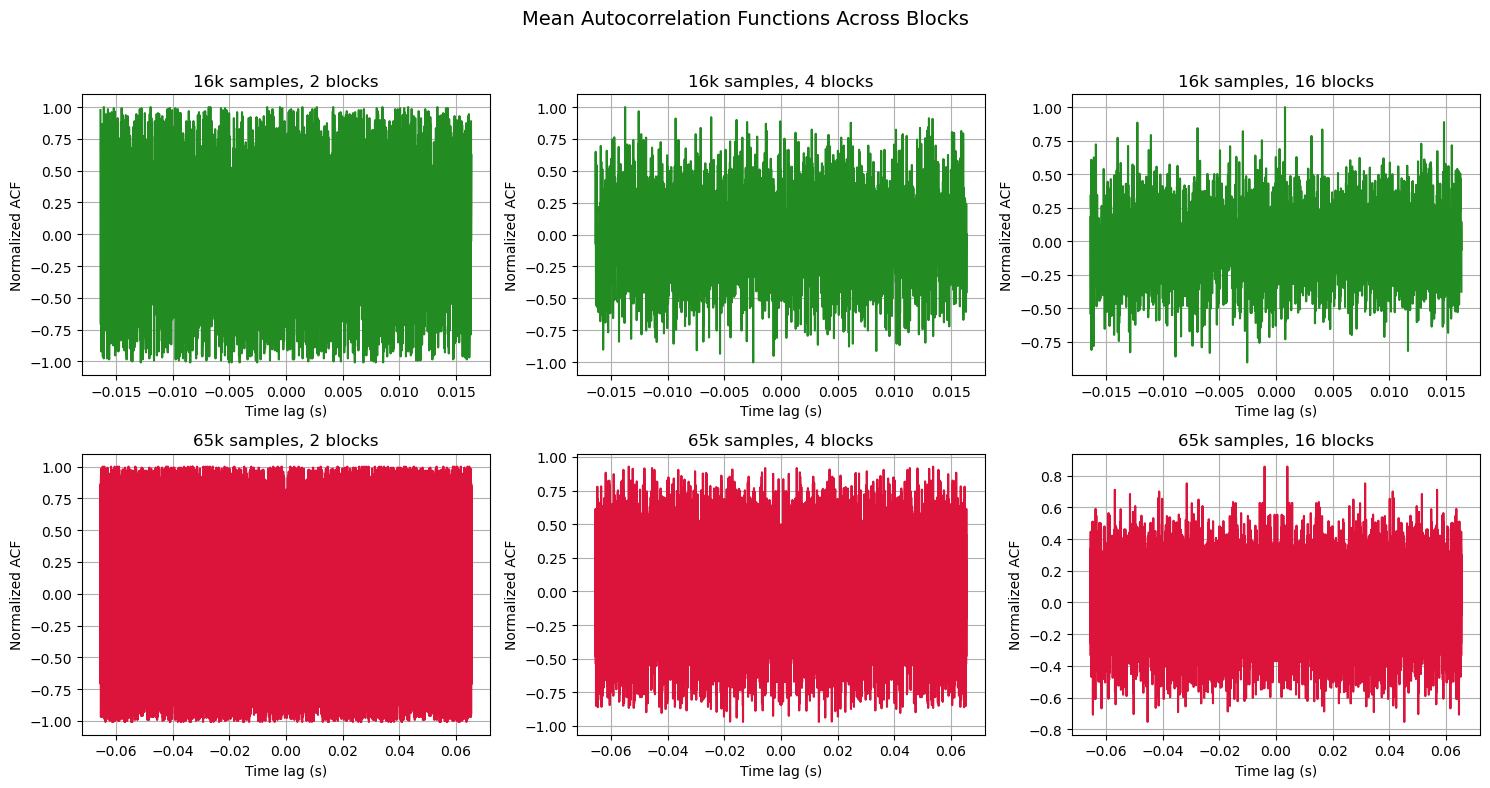

In [15]:
def compute_mean_acf(data):
    
    Nblocks = data.shape[0] if data.ndim > 1 else 1
    acf_accum = np.zeros(2*data.shape[1]-1)
    
    for blk in range(Nblocks):
        acf_accum += np.correlate(data[blk], data[blk], mode='full')
    
    mean_acf = acf_accum / Nblocks
 
    mean_acf /= np.max(mean_acf)
    lags = np.arange(-data.shape[1]+1, data.shape[1])
    return lags, mean_acf


files_16k = {
    2: "noise_1000000Hz_2blocks_16384samples.npz",
    4: "noise_1000000Hz_4blocks_16384samples.npz",
    16: "noise_1000000Hz_16blocks_16384samples.npz",
}

files_65k = {
    2: "noise_1000000Hz_2blocks_65536samples.npz",
    4: "noise_1000000Hz_4blocks_65536samples.npz",
    16: "noise_1000000Hz_16blocks_65536samples.npz",
}

plt.figure(figsize=(15,8))


for i, (Nblocks, fname) in enumerate(files_16k.items()):
    data = np.load(fname)["data"]
    if data.ndim == 1:
        data = data[np.newaxis, :]
    lags, mean_acf = compute_mean_acf(data)

    ds = 10
    plt.subplot(2,3,i+1)
    plt.plot(lags[::ds]/1e6, mean_acf[::ds], color='forestgreen')
    plt.title(f"16k samples, {Nblocks} blocks")
    plt.xlabel("Time lag (s)")
    plt.ylabel("Normalized ACF")
    plt.grid(True)


for i, (Nblocks, fname) in enumerate(files_65k.items()):
    data = np.load(fname)["data"]
    if data.ndim == 1:
        data = data[np.newaxis, :]
    lags, mean_acf = compute_mean_acf(data)
    
    ds = 10
    plt.subplot(2,3,i+4)
    plt.plot(lags[::ds]/1e6, mean_acf[::ds], color='crimson')
    plt.title(f"65k samples, {Nblocks} blocks")
    plt.xlabel("Time lag (s)")
    plt.ylabel("Normalized ACF")
    plt.grid(True)

plt.suptitle("Mean Autocorrelation Functions Across Blocks", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

The plots show the mean autocorrelation function (ACF) of the broadband noise generator signal for two sample lengths (16,384 samples on top row and 65,536 samples on bottom row), averaged across 2, 4, and 16 blocks. The oscillatory structure of the ACF is largely flat, reflecting the broadband random nature of  the noise, and the amplitude decreases for larger time lags due to fewer overlapping points contributing to the correlation. Comparing different numbers of blocks shows that averaging reduces fluctuations in the ACF but does not introduce any periodic structure, consistent with the what we would expect to see with random noise. 

**Conclusion**: Analysis of the histograms of sampled voltages confirm that the noise is approximately Gaussian, with mean near zero and variance scaling with the number of blocks, consistent with the Central Limit Theorem, which states that averaging N blocks reduces the standard deviation of fluctuations by roughly $\sqrt{N}$. Voltage spectra preserve both amplitude and phase information, allowing the computation of the ACF, while the power spectrum provides frequency content but loses the phase information. The ACF of the noise signal shows a peak at zero lag and decays with increasing time lag. The SNR scales as $N^x$ for x=2. 

### 7. Mixers

<h3 style="font-family: Arial; color: mediumblue;"> 7.1. The Double-SideBand (DSB) Mixer </h3>

**Setup:** As double-sideband (DSB) mixer multiplies two input signals, the Radio Frequency (RF) and the Local Oscillator (LO), produce an output which contains the sum and difference of the input frequencies. This output is called the Intermediate Frequency (IF). For this part of the lab, we set the LO to 10 MHz and the RF to 9.8 MHz, producing sum (19.8 MHz) and difference (0.2 MHz) frequencies. Digitally sampling the IF signal allowed us to capture its waveform and compute power spectra, revealing the upper sideband (sum frequency) and lower sideband (difference frequency). Fourier filtering can be applied to remove the sum frequency, leaving only the lower sideband, which demonstrates how mixers separate certain signals in radio systems.

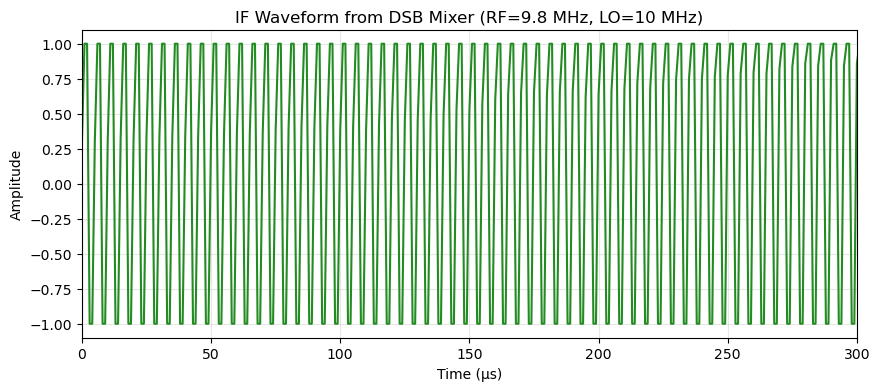

In [16]:
data_file = "7.1dsb_IF_RF9p8_LO10_fs1MHz.npz"
data = np.load(data_file)
x = data["data"]
fs = data["sample_rate"]   
N = len(x)
t = np.arange(N)/fs*1e6  #microsec

plt.figure(figsize=(10,4))
plt.plot(t, x, color='forestgreen')
plt.xlabel("Time (µs)")
plt.ylabel("Amplitude")
plt.xlim(0,300)
plt.title("IF Waveform from DSB Mixer (RF=9.8 MHz, LO=10 MHz)")
plt.grid(True, alpha=0.3)
plt.show()

This plot shows the intermediate frequency (IF) signal produced by the DSB mixer with RF = 9.8 MHz and LO = 10 MHz. The waveform oscillates at the difference frequency of 0.2 MHz, representing the lower sideband of the mixer output. Observing this signal allows us to ensure the presence of the expected frequency before filtering or applying a Fourier analysis.

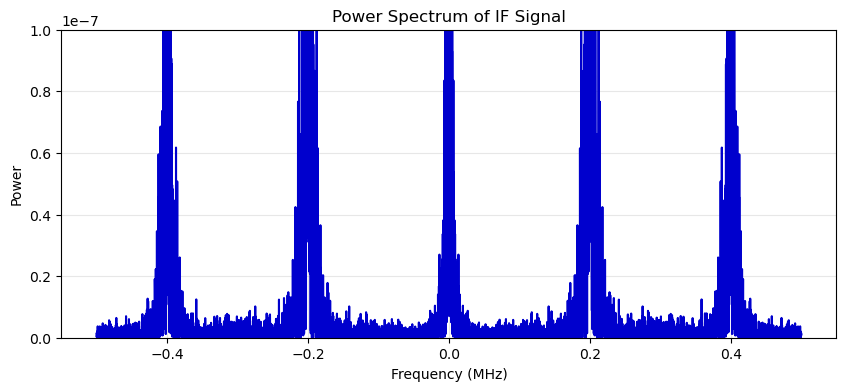

In [17]:
f, P = power_spectrum(x, fs)
plt.figure(figsize=(10,4))
plt.plot(f/1e6, P, color='mediumblue')
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power")
plt.ylim(0, 1e-7)
plt.title("Power Spectrum of IF Signal")
plt.grid(True, alpha=0.3)
plt.show()

The power spectrum of the IF signal reveals two distinct peaks corresponding to the lower sideband (0.2 MHz) symmetric about the zero frequency and the upper sideband. The lower sideband contains the desired information, while the upper sideband demonstrates the mirrored, unwanted component produced by the DSB mixing process. This illustrates how a mixer produces both sum and difference frequencies, and why filtering is necessary to isolate the signal of interest. 

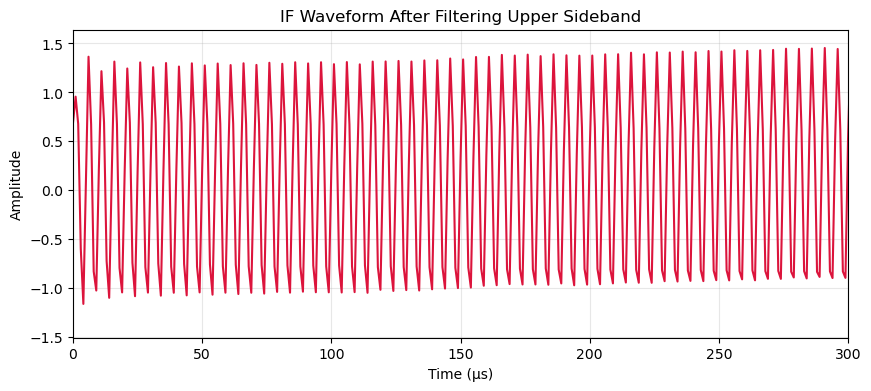

In [18]:
X = np.fft.fft(x)
f_full = np.fft.fftfreq(N, d=1/fs)

threshold = 0.3e6   
X_filtered = X.copy()
X_filtered[np.abs(f_full) > threshold] = 0

x_filtered = np.fft.ifft(X_filtered)

plt.figure(figsize=(10,4))
plt.plot(t, x_filtered.real, color='crimson')
plt.xlabel("Time (µs)")
plt.ylabel("Amplitude")
plt.xlim(0,300)
plt.title("IF Waveform After Filtering Upper Sideband")
plt.grid(True, alpha=0.3)
plt.show()

This plot shows the IF signal after Fourier filtering to remove the upper sideband. Only the lower sideband at 0.2 MHz remains, preserving the desired beat frequency while eliminating the high frequency sum component. This demonstrates the effectiveness of frequency filtering for isolating signals in a double sideband mixer, and that the lower sideband can be extracted for further analysis.

<h3 style="font-family: Arial; color: mediumblue;"> 7.2. Intermodulation Products in Real Mixers </h3>

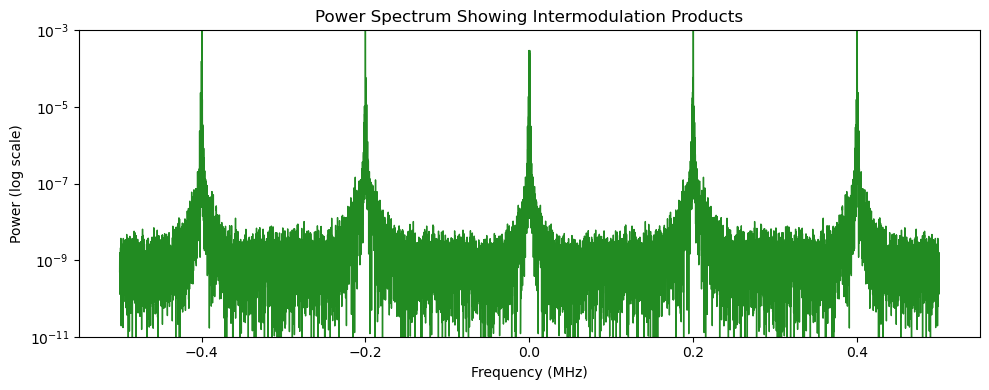

In [19]:
data = np.load("7.1dsb_IF_RF9p8_LO10_fs1MHz.npz")
x = data["data"]
fs = 1e6 

f, P = power_spectrum(x, fs)

plt.figure(figsize=(10,4))

plt.plot(f/1e6, P, linewidth=1, color='forestgreen')

plt.yscale("log")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (log scale)")
plt.ylim(1e-11, 1e-3)
plt.title("Power Spectrum Showing Intermodulation Products")

plt.tight_layout()
plt.show()

This figure shows the logarithmic power spectrum of the mixer IF output showing intermodulation products. 
The IF power spectrum is plotted on a logarithmic vertical axis, revealing a dense "forest" of spectral lines surrounding the expected difference frequency at $\lvert \nu_{\mathrm{LO}} - \nu_{\mathrm{RF}} \rvert = 0.2~\mathrm{MHz}$. 
These additional peaks arise from nonlinear behavior in the real diode mixer, producing intermodulation products at frequencies of the form $\lvert m\nu_{\mathrm{LO}} \pm n\nu_{\mathrm{RF}} \rvert$ for integers $m$ and $n$. 
This "forest" becomes visible on a logarithmic scale, showing how real mixers introduce additional frequency components to the expected IF signal.

<h3 style="font-family: Arial; color: mediumblue;"> 7.3. The Single-Sideband Mixer (SSB Mixer) </h3>

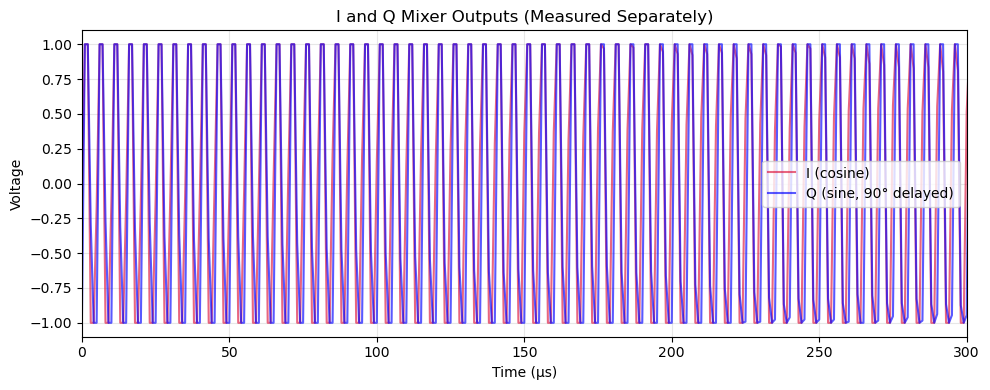

In [20]:
fs = 1.0e6

I_data = np.load("IF_from_KeysightLO10MHz_RF9p8MHz.npz")["data"]
Q_data = np.load("IF_from_KeysightN9310A_10MHz_delayedLO_RF9p8MHz_CH2.npz")["data"]

N = min(len(I_data), len(Q_data))
I = I_data[:N]
Q = Q_data[:N]

x_IQ = I + 1j * Q

t = np.arange(N) / fs * 1e6  # µs

plt.figure(figsize=(10,4))
plt.plot(t, I, label="I (cosine)", alpha=0.65, color='crimson')
plt.plot(t, Q, label="Q (sine, 90° delayed)", alpha=0.65, color="blue")
plt.xlabel("Time (µs)")
plt.ylabel("Voltage")
plt.xlim(0,300)
plt.title("I and Q Mixer Outputs (Measured Separately)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

This figure demonstrates the phase delay between the in-phase (I) and quadrature (Q) outputs of the SSB mixer, measured. The Q channel is produced by introducing a $90^\circ$ phase delay in the local oscillator (LO) path, resulting in sine and cosine mixing components. Together, these signals form the complex IQ representation of the intermediate frequency.

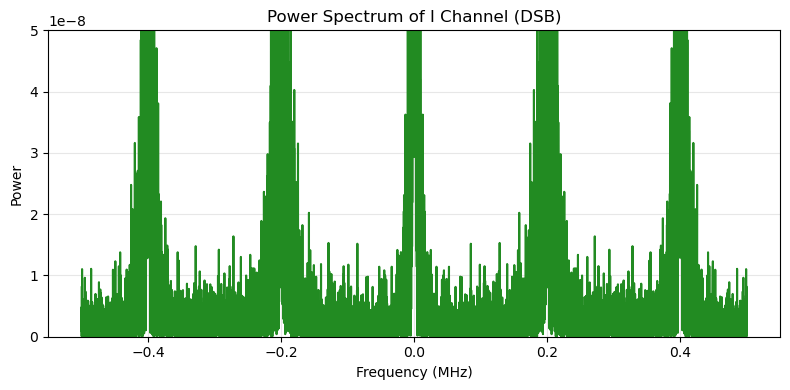

In [21]:
f_I, P_I = power_spectrum(I, fs)

plt.figure(figsize=(8,4))
plt.plot(f_I/1e6, P_I, color='forestgreen')
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power")
plt.title("Power Spectrum of I Channel (DSB)")
plt.ylim(0,5e-8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Power spectrum of the in-phase (I) mixer output. The spectrum exhibits conjugate symmetry about zero frequency.

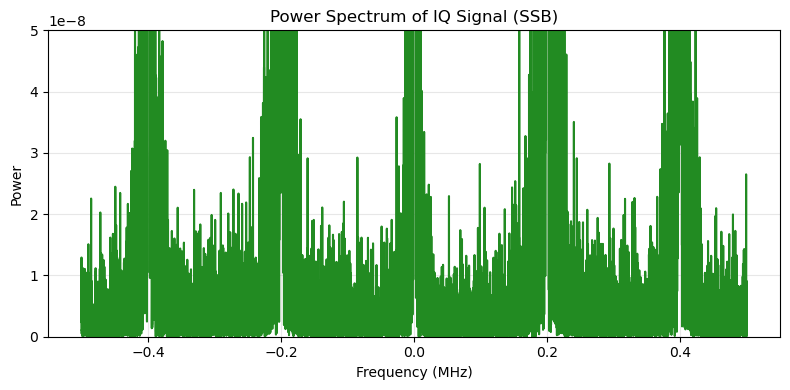

In [22]:
f_IQ, X_IQ = compute_fft(x_IQ, fs, window='hann')
P_IQ = np.abs(X_IQ)**2 / N**2

plt.figure(figsize=(8,4))
plt.plot(f_IQ/1e6, P_IQ, color='forestgreen')
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power")
plt.ylim(0, 5e-8)
plt.title("Power Spectrum of IQ Signal (SSB)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Power spectrum of the complex IQ signal formed from the measured I and Q channels.

**Conclusion**: The single sideband (SSB) mixer was made by combining two double sideband (DSB) mixers and adding a 90° phase shift to one of the local oscillator paths. This gave two outputs, called I (in phase) and Q (quadrature), which were measured separately. Together, they form a complex signal that shows both positive and negative frequencies in the Fourier transform. Unlike the normal DSB output, which has both sidebands, the SSB mixer removes one sideband. This shows how SSB mixers can isolate a single frequency and make it easier to tell which way the signal is moving in frequency.